In [9]:
# import pandas as pd
# from torch.utils.data import DataLoader, Dataset
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
# from transformers import get_linear_schedule_with_warmup
# import torch
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# # 데이터 로드
# df = pd.read_csv('data/moralTrain.csv')

# # 일부 데이터 랜덤으로 사용
# df = df.sample(n=1000, random_state=42)

# # KoBERT 토크나이저 로드
# tokenizer = BertTokenizer.from_pretrained('kykim/bert-kor-base')

# # 데이터셋 정의
# class HateSpeechDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_len=128):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_len = max_len
        
#     def __len__(self):
#         return len(self.texts)
    
#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]
        
#         inputs = self.tokenizer.encode_plus(
#             text,
#             None,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding='max_length',
#             return_token_type_ids=False,
#             truncation=True,
#             return_attention_mask=True,
#             return_tensors='pt'
#         )
        
#         return {
#             'input_ids': inputs['input_ids'].flatten(),
#             'attention_mask': inputs['attention_mask'].flatten(),
#             'labels': torch.tensor(label, dtype=torch.long)
#         }
    
# # 데이터 준비
# X_train, X_test, y_train, y_test = train_test_split(df['text'], df['types'], test_size=0.2, random_state=42)

# train_dataset = HateSpeechDataset(X_train.tolist(), y_train.tolist(), tokenizer)
# test_dataset = HateSpeechDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # 모델 로드 및 파인 튜닝
# config = BertConfig.from_pretrained('kykim/bert-kor-base', hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3, num_labels=6)
# model = BertForSequenceClassification.from_pretrained('kykim/bert-kor-base', config=config)
# model.cuda()

# optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
# total_steps = len(train_loader) * 5
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# # 조기 종료 클래스
# class EarlyStopping:
#     def __init__(self, patience=3, verbose=False, delta=0):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.val_loss_min = float('inf')
#         self.delta = delta

#     def __call__(self, val_loss, model):
#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             if self.verbose:
#                 print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#             self.counter = 0

#     def save_checkpoint(self, val_loss, model):
#         if self.verbose:
#             print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), 'checkpoint.pt')
#         self.val_loss_min = val_loss

# early_stopping = EarlyStopping(patience=3, verbose=True)

# # 모델 학습
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train_loss_values = []
# train_accuracy_values = []
# val_loss_values = []
# val_accuracy_values = []

# for epoch in range(5):
#     model.train()
#     train_loss = 0.0
#     train_correct = 0
#     train_total = 0
    
#     for batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
#         optimizer.zero_grad()
#         inputs = {key: value.to(device) for key, value in batch.items()}
#         outputs = model(**inputs)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         train_loss += loss.item()
#         preds = outputs.logits.argmax(dim=1)
#         train_correct += (preds == inputs['labels']).sum().item()
#         train_total += inputs['labels'].size(0)
    
#     avg_train_loss = train_loss / len(train_loader)
#     train_accuracy = train_correct / train_total

#     train_loss_values.append(avg_train_loss)
#     train_accuracy_values.append(train_accuracy)
    
#     model.eval()
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0
    
#     with torch.no_grad():
#         for batch in tqdm(test_loader, desc=f'Validation Epoch {epoch+1}'):
#             inputs = {key: value.to(device) for key, value in batch.items()}
#             outputs = model(**inputs)
#             loss = outputs.loss

#             val_loss += loss.item()
#             preds = outputs.logits.argmax(dim=1)
#             val_correct += (preds == inputs['labels']).sum().item()
#             val_total += inputs['labels'].size(0)
    
#     avg_val_loss = val_loss / len(test_loader)
#     val_accuracy = val_correct / val_total
    
#     val_loss_values.append(avg_val_loss)
#     val_accuracy_values.append(val_accuracy)

#     print(f'Epoch {epoch+1}/{5}')
#     print(f'Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}')
#     print(f'Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')

# # 모델 저장
# model.save_pretrained('./saved_model')
# tokenizer.save_pretrained('./saved_model')

# # 결과 시각화
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_loss_values, label='Train Loss')
# plt.plot(val_loss_values, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracy_values, label='Train Accuracy')
# plt.plot(val_accuracy_values, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy Over Epochs')

# plt.savefig('loss_and_accuracy.png')

# plt.show()    

In [10]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
# 데이터 로드
df = pd.read_csv('data/moralTrain.csv')

# 일부 데이터 랜덤으로 사용
df = df.sample(n=10000, random_state=42)

In [12]:
# KoBERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('kykim/bert-kor-base')

# 데이터셋 정의
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

c:\Users\jhy97\anaconda3\envs\tensor\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['types'], test_size=0.2, random_state=42)

train_dataset = HateSpeechDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = HateSpeechDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 로드 및 파인 튜닝
config = BertConfig.from_pretrained('kykim/bert-kor-base', hidden_dropout_prob=0.4, attention_probs_dropout_prob=0.4, num_labels=6)
model = BertForSequenceClassification.from_pretrained('kykim/bert-kor-base', config=config)
model.cuda()

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.1)
total_steps = len(train_loader) * 20
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [14]:
# # 조기 종료 클래스
# class EarlyStopping:
#     def __init__(self, patience=3, verbose=False, delta=0):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.val_loss_min = float('inf')
#         self.delta = delta

#     def __call__(self, val_loss, model):
#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             if self.verbose:
#                 print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#             self.counter = 0

#     def save_checkpoint(self, val_loss, model):
#         if self.verbose:
#             print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), 'checkpoint.pt')
#         self.val_loss_min = val_loss

# early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.01)

In [15]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(20):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
        optimizer.zero_grad()
        inputs = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        train_correct += (preds == inputs['labels']).sum().item()
        train_total += inputs['labels'].size(0)
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total

    train_loss_values.append(avg_train_loss)
    train_accuracy_values.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f'Validation Epoch {epoch+1}'):
            inputs = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss

            val_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            val_correct += (preds == inputs['labels']).sum().item()
            val_total += inputs['labels'].size(0)
    
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = val_correct / val_total
    
    val_loss_values.append(avg_val_loss)
    val_accuracy_values.append(val_accuracy)

    print(f'Epoch {epoch+1}/{20}')
    print(f'Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')

    # early_stopping(avg_val_loss, model)
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break

Validation Epoch 1: 100%|██████████| 125/125 [00:09<00:00, 12.74it/s]


Epoch 1/20
Train Loss: 1.3699 | Train Accuracy: 0.4417
Val Loss: 1.3099 | Val Accuracy: 0.5170


Validation Epoch 2: 100%|██████████| 125/125 [00:10<00:00, 12.15it/s]


Epoch 2/20
Train Loss: 1.3001 | Train Accuracy: 0.4911
Val Loss: 1.1985 | Val Accuracy: 0.5520


Validation Epoch 3: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s]


Epoch 3/20
Train Loss: 1.2602 | Train Accuracy: 0.5196
Val Loss: 1.1572 | Val Accuracy: 0.5785


Validation Epoch 4: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s]


Epoch 4/20
Train Loss: 1.2258 | Train Accuracy: 0.5531
Val Loss: 1.0917 | Val Accuracy: 0.6065


Validation Epoch 5: 100%|██████████| 125/125 [00:10<00:00, 11.90it/s]


Epoch 5/20
Train Loss: 1.1939 | Train Accuracy: 0.5734
Val Loss: 1.1001 | Val Accuracy: 0.5985


Validation Epoch 6: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s]


Epoch 6/20
Train Loss: 1.1660 | Train Accuracy: 0.5804
Val Loss: 1.0731 | Val Accuracy: 0.6085


Validation Epoch 7: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s]


Epoch 7/20
Train Loss: 1.1493 | Train Accuracy: 0.5906
Val Loss: 1.0869 | Val Accuracy: 0.6075


Validation Epoch 8: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s]


Epoch 8/20
Train Loss: 1.1459 | Train Accuracy: 0.5907
Val Loss: 1.0812 | Val Accuracy: 0.6055


Validation Epoch 9: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s]


Epoch 9/20
Train Loss: 1.1274 | Train Accuracy: 0.6029
Val Loss: 1.0934 | Val Accuracy: 0.5980


Validation Epoch 10: 100%|██████████| 125/125 [00:10<00:00, 11.96it/s]


Epoch 10/20
Train Loss: 1.1147 | Train Accuracy: 0.6042
Val Loss: 1.0358 | Val Accuracy: 0.6300


Validation Epoch 11: 100%|██████████| 125/125 [00:10<00:00, 11.96it/s]


Epoch 11/20
Train Loss: 1.1125 | Train Accuracy: 0.6086
Val Loss: 1.0482 | Val Accuracy: 0.6200


Validation Epoch 12: 100%|██████████| 125/125 [00:10<00:00, 12.09it/s]


Epoch 12/20
Train Loss: 1.0889 | Train Accuracy: 0.6158
Val Loss: 1.0267 | Val Accuracy: 0.6295


Validation Epoch 13: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s]


Epoch 13/20
Train Loss: 1.0761 | Train Accuracy: 0.6092
Val Loss: 1.0487 | Val Accuracy: 0.6230


Validation Epoch 14: 100%|██████████| 125/125 [00:10<00:00, 12.14it/s]


Epoch 14/20
Train Loss: 1.0648 | Train Accuracy: 0.6235
Val Loss: 1.0540 | Val Accuracy: 0.6180


Validation Epoch 15: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s]


Epoch 15/20
Train Loss: 1.0590 | Train Accuracy: 0.6246
Val Loss: 1.0063 | Val Accuracy: 0.6340


Validation Epoch 16: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s]


Epoch 16/20
Train Loss: 1.0474 | Train Accuracy: 0.6218
Val Loss: 1.0233 | Val Accuracy: 0.6315


Validation Epoch 17: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s]


Epoch 17/20
Train Loss: 1.0467 | Train Accuracy: 0.6231
Val Loss: 1.0174 | Val Accuracy: 0.6320


Validation Epoch 18: 100%|██████████| 125/125 [00:10<00:00, 12.10it/s]


Epoch 18/20
Train Loss: 1.0461 | Train Accuracy: 0.6221
Val Loss: 1.0262 | Val Accuracy: 0.6350


Validation Epoch 19: 100%|██████████| 125/125 [00:10<00:00, 12.01it/s]


Epoch 19/20
Train Loss: 1.0280 | Train Accuracy: 0.6311
Val Loss: 1.0295 | Val Accuracy: 0.6315


Validation Epoch 20: 100%|██████████| 125/125 [00:10<00:00, 12.06it/s]

Epoch 20/20
Train Loss: 1.0243 | Train Accuracy: 0.6308
Val Loss: 1.0251 | Val Accuracy: 0.6335


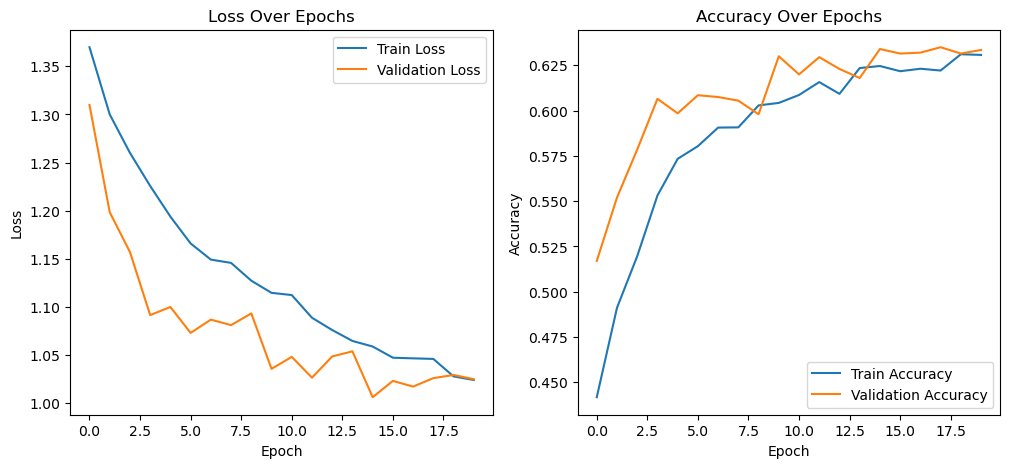

: 

In [16]:
# 모델 저장
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

# 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Train Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.savefig('loss_and_accuracy.png')

plt.show()